In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import sys
import scipy.stats as stats
import scipy.optimize as opt
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform


from sklearn.decomposition import PCA
import os

import pyarrow as pa
import pyarrow.parquet as pq

from enum import Enum

from matplotlib.backends.backend_pdf import PdfPages 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# 30 sec

In [2]:
sys.path.append('/groups/icecube/cyan/Utils')
from PlotUtils import setMplParam, getColour, getHistoParam 
from ExternalFunctions import nice_string_output, add_text_to_ax
setMplParam()

In [3]:
# Now import from Enum
sys.path.append('/groups/icecube/cyan/factory/DOMification')
from Enum.Flavour import Flavour
from Enum.EnergyRange import EnergyRange
from EventPeek.PseudoNormaliser import PseudoNormaliser

In [4]:
root_dir_noCR = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/PureNu/"
root_dir_noCR_CC = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean/"
root_dir_noCR_CC_IN = "/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/"

In [5]:
Flavour.E.latex

'\\nu_e'

In [6]:
EnergyRange.ER_10_TEV_1_PEV.E

'22014'

In [7]:
EnergyRange.ER_10_TEV_1_PEV.latex

'$10\\,\\text{TeV} - 1\\,\\text{PeV}$'

In [8]:
dir_noCR_CC_IN_nu_e_10TeV_1PeV = os.path.join(root_dir_noCR_CC_IN, EnergyRange.ER_10_TEV_1_PEV.E)


In [9]:
dir_noCR_CC_IN_nu_e_10TeV_1PeV

'/lustre/hpc/project/icecube/HE_Nu_Aske_Oct2024/PMTfied_filtered/Snowstorm/CC_CRclean_Contained/22014'

In [10]:
def get_normalised_dom_features(pmt_event_df: pd.DataFrame, Q_cut: float = -1) -> pd.DataFrame:
    selected_columns = ["dom_x", "dom_y", "dom_z", "Qtotal", "t1"]
    event_np = pmt_event_df[selected_columns].to_numpy()
    normaliser = PseudoNormaliser()
    
    normalised_np = normaliser(event_np, column_names=selected_columns)
    normalised_df = pd.DataFrame(normalised_np, columns=selected_columns)
    normalised_df[["dom_x", "dom_y", "dom_z"]] = pmt_event_df[["dom_x", "dom_y", "dom_z"]].to_numpy()
    normalised_df = normalised_df[normalised_df["Qtotal"] > Q_cut] if Q_cut is not None else normalised_df

    return normalised_df

In [11]:
def add_string_column_to_event_df(event_df: pd.DataFrame, ref_position_df: pd.DataFrame, tolerance=2.0):
    event_df = event_df.copy()  # Work on a copy to avoid modifying the original DataFrame

    # Create a new 'string' column and initialize it with NaN
    event_df['string'] = np.nan

    # Loop through each DOM in the event_df and find the closest match in position_df
    for idx, row in event_df.iterrows():
        # Calculate distances in x, y (we ignore z here, as it's not relevant for string determination)
        distances = np.sqrt((ref_position_df['dom_x'] - row['dom_x'])**2 + (ref_position_df['dom_y'] - row['dom_y'])**2)
        
        # Find the minimum distance, and check if it is within the tolerance
        min_distance_idx = distances.idxmin()
        if distances[min_distance_idx] <= tolerance:
            # Assign the string number from the reference position
            event_df.at[idx, 'string'] = ref_position_df.at[min_distance_idx, 'string']
    
    return event_df

In [12]:
from scipy.spatial import ConvexHull

def calculate_horizontal_boundary(pmt_event_df: pd.DataFrame):
    xy_points = pmt_event_df[['dom_x', 'dom_y']].drop_duplicates().to_numpy()
    
    if xy_points.shape[0] < 3:  # Ensure at least 3 unique points
        return xy_points  # Return points as-is (skip ConvexHull)
    
    try:
        hull = ConvexHull(xy_points)
        boundary_points = xy_points[hull.vertices]
    except QhullError:
        print("ConvexHull failed: Points are nearly collinear. Returning input points.")
        boundary_points = xy_points  # Fallback: Use input points
    
    return boundary_points


In [13]:
def calculate_horizontal_PCA(boundary_points: np.ndarray):
    # Compute the mean (centre) of the shape
    centre = np.mean(boundary_points, axis=0)

    # Perform PCA to find the principal axes
    pca = PCA(n_components=2)
    pca.fit(boundary_points)

    # Extract eigenvalues and eigenvectors
    eigenvalues = pca.explained_variance_
    eigenvectors = pca.components_

    # Compute major and minor axis lengths (sqrt of eigenvalues)
    major_axis_length, minor_axis_length = np.sqrt(eigenvalues)

    return major_axis_length, minor_axis_length, eigenvectors, centre

In [14]:
def compute_max_extent(boundary_points: np.ndarray) -> tuple:
    dist_matrix = squareform(pdist(boundary_points))  # Compute all pairwise distances
    i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)  # Find indices of max distance
    point1, point2 = boundary_points[i], boundary_points[j]
    
    return point1, point2, dist_matrix[i, j]

In [15]:
def calculate_vertical_stretch(pmt_event_df: pd.DataFrame):
    stretch_per_string = pmt_event_df.groupby("string")["dom_z"].agg(lambda x: x.max() - x.min())

    mean_z_stretch = stretch_per_string.mean()
    max_z_stretch = stretch_per_string.max()

    mean_string = (stretch_per_string - mean_z_stretch).abs().idxmin()  # String closest to mean stretch
    max_string = stretch_per_string.idxmax()  # String with max stretch

    # Get Z min/max positions for the selected strings
    mean_z_positions = pmt_event_df.loc[pmt_event_df["string"] == mean_string, "dom_z"].agg(["min", "max"]).values
    max_z_positions = pmt_event_df.loc[pmt_event_df["string"] == max_string, "dom_z"].agg(["min", "max"]).values

    return mean_z_stretch, max_z_stretch, mean_z_positions, max_z_positions


In [16]:
def get_extent_stretch_shard(pmt_event_df: pd.DataFrame, Q_cut:int = -1):
    ref_position_file = "/groups/icecube/cyan/factory/DOMification/dom_ref_pos/unique_string_dom_completed.csv"
    ref_position_df = pd.read_csv(ref_position_file)

    # Normalise the event DataFrame
    pseudo_normalised_df = get_normalised_dom_features(pmt_event_df, Q_cut)
    pseudo_normalised_df = add_string_column_to_event_df(pseudo_normalised_df, ref_position_df)
    border_xy = calculate_horizontal_boundary(pseudo_normalised_df)
    # major_axis_length, minor_axis_length, eigenvectors, centre = calculate_horizontal_PCA(pseudo_normalised_df)
    xy_end1, xy_end2, max_extent_2d = compute_max_extent(border_xy)
    mean_z_stretch, max_z_stretch, mean_z_positions, max_z_positions = calculate_vertical_stretch(pseudo_normalised_df)
    
    return max_extent_2d, max_z_stretch
    

In [17]:
def plot_dist_extent(extents_e: np.ndarray, 
                     extents_mu: np.ndarray,
                     extents_tau: np.ndarray,
                     title: str):
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(extents_mu, binwidth = 50, isLog=False, isDensity = False)
    fig, ax = plt.subplots(figsize=(13, 9))
    ax.hist(extents_e, bins=bins, color=getColour(2), histtype='step', label=r'$\nu_e$', linewidth=2, hatch='/')
    ax.hist(extents_mu, bins=bins, color=getColour(0), histtype='step', label=r'$\nu_\mu$', linewidth=2, hatch='\\')
    ax.hist(extents_tau, bins=bins, color=getColour(1), histtype='step', label=r'$\nu_\tau$', linewidth=2, hatch='--')

    ax.legend()
    ax.set_xlabel(r'Extent [m]')
    ax.set_ylabel('Counts')
    ax.set_title(fr"{title}")
    
    d = {'N events': len(extents_e),
         'binwidth': f"{binwidth:.1f}",
         'Nbins': Nbins}
    
    d_e = {r'$\nu_e$': '',
           'max': f"{np.max(extents_e):.2f}",
           'min': f"{np.min(extents_e):.2f}",
        'mean': f"{np.mean(extents_e):.2f}",
        'median': f"{np.median(extents_e):.2f}",
        'std': f"{np.std(extents_e):.2f}"}
    d_mu = {r'$\nu_\mu$': '',
                'max': f"{np.max(extents_mu):.2f}",
                'min': f"{np.min(extents_mu):.2f}",
        'mean': f"{np.mean(extents_mu):.2f}",
        'median': f"{np.median(extents_mu):.2f}",
        'std': f"{np.std(extents_mu):.2f}"}
    d_tau = {r'$\nu_\tau$': '',
        'max': f"{np.max(extents_tau):.2f}",
        'min': f"{np.min(extents_tau):.2f}",
        'mean': f"{np.mean(extents_tau):.2f}",
        'median': f"{np.median(extents_tau):.2f}",
        'std': f"{np.std(extents_tau):.2f}"}

    add_text_to_ax(0.75, 0.95, nice_string_output(d), ax, fontsize=10, color='black')
    add_text_to_ax(0.02, 0.95, nice_string_output(d_e), ax, fontsize=10, color='black')
    add_text_to_ax(0.22, 0.95, nice_string_output(d_mu), ax, fontsize=10, color='black')
    add_text_to_ax(0.42, 0.95, nice_string_output(d_tau), ax, fontsize=10, color='black')


In [18]:
def plot_dist_stretch(stretches_e: np.ndarray, 
                      stretches_mu: np.ndarray,
                      stretches_tau: np.ndarray,
                      title: str):
    Nbins, binwidth, bins, counts, bin_centers = getHistoParam(stretches_mu, binwidth = 20, isLog=False, isDensity = False)
    fig, ax = plt.subplots(figsize=(13, 9))
    ax.hist(stretches_e, bins=bins, color=getColour(2), histtype='step', label=r'$\nu_e$', linewidth=2)
    ax.hist(stretches_mu, bins=bins, color=getColour(0), histtype='step', label=r'$\nu_\mu$', linewidth=2)
    ax.hist(stretches_tau, bins=bins, color=getColour(1), histtype='step', label=r'$\nu_\tau$', linewidth=2)

    ax.legend()
    ax.set_xlabel(r'Stretch [m]')
    ax.set_ylabel('Counts')
    ax.set_title(fr"{title}")
    
    d = {'N events': len(stretches_e),
         'binwidth': f"{binwidth:.1f}",
         'Nbins': Nbins}
    
    d_e = {r'$\nu_e$': '',
           'max': f"{np.max(stretches_e):.2f}",
           'min': f"{np.min(stretches_e):.2f}",
           'mean': f"{np.mean(stretches_e):.2f}",
        'median': f"{np.median(stretches_e):.2f}",
        'std': f"{np.std(stretches_e):.2f}"}
    d_mu = {r'$\nu_\mu$': '',
                'max': f"{np.max(stretches_mu):.2f}",
                'min': f"{np.min(stretches_mu):.2f}",
        'mean': f"{np.mean(stretches_mu):.2f}",
        'median': f"{np.median(stretches_mu):.2f}",
        'std': f"{np.std(stretches_mu):.2f}"}
    d_tau = {r'$\nu_\tau$': '',
        'max': f"{np.max(stretches_tau):.2f}",
        'min': f"{np.min(stretches_tau):.2f}",
        'mean': f"{np.mean(stretches_tau):.2f}",
        'median': f"{np.median(stretches_tau):.2f}",
        'std': f"{np.std(stretches_tau):.2f}"}

    add_text_to_ax(0.75, 0.95, nice_string_output(d), ax, fontsize=10, color='black')
    add_text_to_ax(0.02, 0.95, nice_string_output(d_e), ax, fontsize=10, color='black')
    add_text_to_ax(0.22, 0.95, nice_string_output(d_mu), ax, fontsize=10, color='black')
    add_text_to_ax(0.42, 0.95, nice_string_output(d_tau), ax, fontsize=10, color='black')

In [22]:
def collect_extent_stretch_shards_from_different_flavours(root_before_subdir: str, er: EnergyRange, part: int, shard: int, Q_cut: int = -100):
    # Containers to store extents and stretches for each flavour
    extent_data = {Flavour.E: [], Flavour.MU: [], Flavour.TAU: []}
    stretch_data = {Flavour.E: [], Flavour.MU: [], Flavour.TAU: []}

    flavours = [Flavour.E, Flavour.MU, Flavour.TAU]
    
    for flavour in flavours:
        subdir = os.path.join(root_before_subdir, EnergyRange.get_subdir(er, flavour))
        pmt_file = os.path.join(subdir, str(part), f"PMTfied_{int(shard)}.parquet")
        pmt_df = pq.read_table(pmt_file).to_pandas()
        
        pmt_df_grouped = list(pmt_df.groupby("event_no"))[:100]  # Take only the first 10 events
        
        for event_no, event_df in pmt_df_grouped:
            # Compute extent and stretch for this event
            extent, stretch = get_extent_stretch_shard(pmt_event_df=event_df, Q_cut=Q_cut)
            
            # Append to respective flavour lists
            extent_data[flavour].append(extent)
            stretch_data[flavour].append(stretch)

    # Convert lists to numpy arrays
    extents_e = np.array(extent_data[Flavour.E])
    extents_mu = np.array(extent_data[Flavour.MU])
    extents_tau = np.array(extent_data[Flavour.TAU])

    stretches_e = np.array(stretch_data[Flavour.E])
    stretches_mu = np.array(stretch_data[Flavour.MU])
    stretches_tau = np.array(stretch_data[Flavour.TAU])

    # Plot combined distributions
    plot_dist_extent(extents_e, extents_mu, extents_tau, f"Max Extent Distribution for {er.latex}  ($Q_{{\\text{{adjusted}}}}$ > {Q_cut})")
    plot_dist_stretch(stretches_e, stretches_mu, stretches_tau, f"Max Stretch Distribution for {er.latex} ($Q_{{\\text{{adjusted}}}}$ > {Q_cut})")


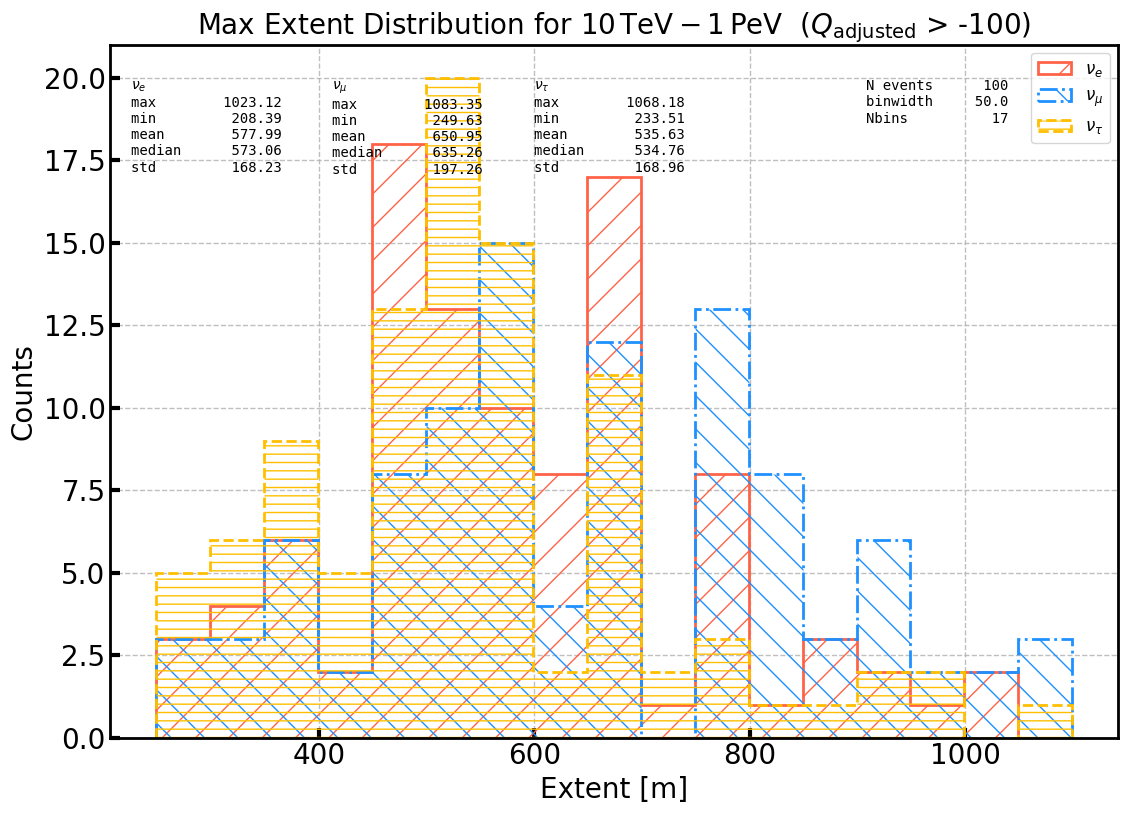

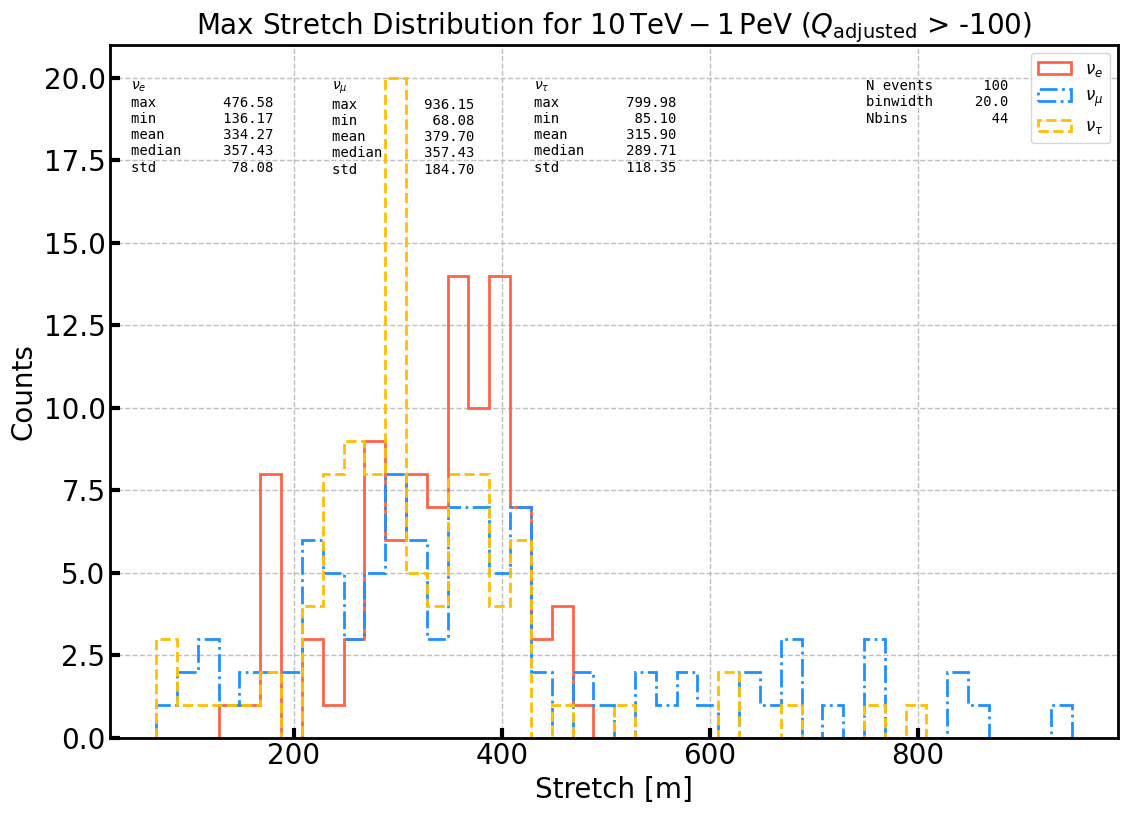

In [23]:
collect_extent_stretch_shards_from_different_flavours(root_before_subdir=root_dir_noCR_CC_IN, 
                                                      er=EnergyRange.ER_10_TEV_1_PEV, 
                                                      part=1, shard=1)
# 5 events : 5 sec
# 10 events: 10 sec
# 100 events: 25 sec
# 1000 events: 3 m 30 sec = 210 sec

In [21]:
haha

NameError: name 'haha' is not defined

In [ ]:
collect_extent_stretch_shards_from_different_flavours(root_before_subdir=root_dir_noCR_CC_IN, 
                                                      er=EnergyRange.ER_10_TEV_1_PEV, 
                                                      part=1, shard=1, Q_cut=-1)
# 5 events : 
# 10 events: 
# 100 events: 
# 1000 events: 3 m 30 sec = 210 sec

IndexError: index 0 is out of bounds for axis 0 with size 0

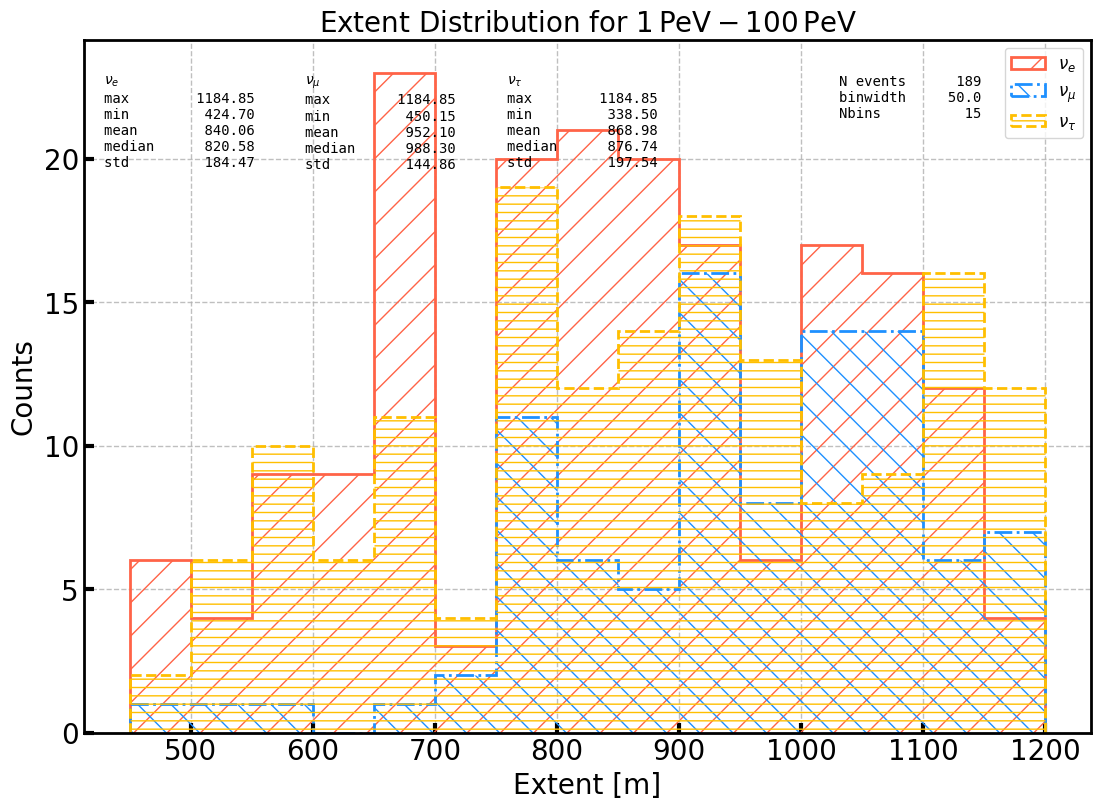

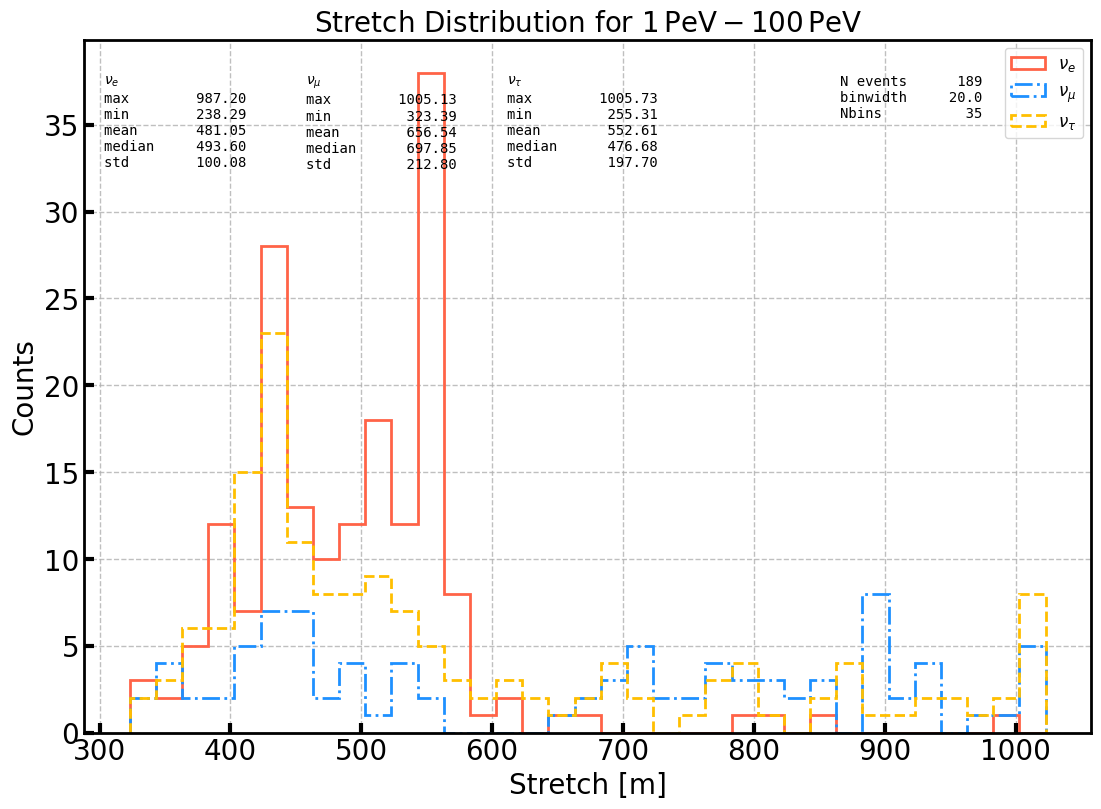

In [ ]:
collect_extent_stretch_shards_from_different_flavours(root_before_subdir=root_dir_noCR_CC_IN, 
                                                      er=EnergyRange.ER_1_PEV_100_PEV,
                                                      part=1, shard=1)
# 5 events : 5 sec
# 10 events: 10 sec
# 100 events: 25 sec
# 1000 events: 3 m 30 sec = 210 sec

In [ ]:
collect_extent_stretch_shards_from_different_flavours(root_before_subdir=root_dir_noCR_CC_IN, 
                                                      er=EnergyRange.ER_1_PEV_100_PEV,
                                                      part=1, shard=1, Q_cut=0)

$$
Q_{\text{shifted}} = \log_{10}(Q) - 2
$$


### double bang: 
1. first $\nu_{\tau}$ CC interaction
2. $\tau$ decay
* the distance between the two cascades depends on the tau decay length   
[tau decay length $<L_{\tau}> \approx 50 \cdot E_\tau (m/PeV)$](https://arxiv.org/abs/1908.05506)
  * 1 Pev tau decay length is 50 meters
  * 10 Pev tau decay length is 500 meters
  * 100 Pev tau decay length is 5000 meters